# Random Forest Regression for Soil Moisture Prediction in Apayao

### Data Preparation and Feature Engineering

Original Soil Moisture Series:
Soil Moisture (mm) - ADF Statistic: -5.114
Soil Moisture (mm) - p-value: 0.000
Soil Moisture (mm) is stationary (p < 0.05).


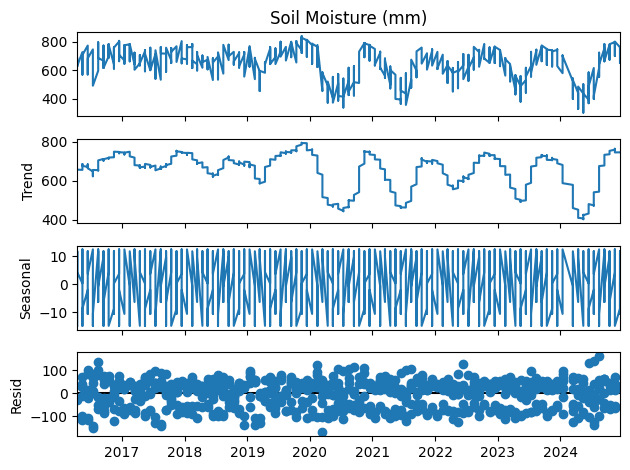

Seasonal component relative strength: 0.078


In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from math import log, sqrt
import matplotlib.pyplot as plt
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('Apayao.csv')

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y')

# Sort by time
df = df.sort_values('Time')

# Create lag features (t-1, t-2, t-3) for soil moisture
df['Soil_Moisture_Lag1'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(1)
df['Soil_Moisture_Lag2'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(2)
df['Soil_Moisture_Lag3'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(3)

# Drop rows with NaN values (first 3 rows for each municipality)
df = df.dropna()

# Define features and target
# We'll use soil moisture as a feature
X = df[['Soil_Moisture_Lag1', 'Soil_Moisture_Lag2', 'Soil_Moisture_Lag3']]
y = df['Soil Moisture (mm)']

from statsmodels.tsa.stattools import adfuller


def check_stationarity(series, signif=0.05, series_name="Series"):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"{series_name} - ADF Statistic: {result[0]:.3f}")
    print(f"{series_name} - p-value: {p_value:.3f}")
    if p_value < signif:
        print(f"{series_name} is stationary (p < {signif}).")
        return True
    else:
        print(f"{series_name} is not stationary (p >= {signif}).")
        return False


# Check stationarity for the original soil moisture data
soil_moisture_series = df['Soil Moisture (mm)']
print("Original Soil Moisture Series:")
is_stationary = check_stationarity(soil_moisture_series, series_name="Soil Moisture (mm)")

# Check for seasonality for the original soil moisture data
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index('Time')

# Extract the soil moisture series
soil_moisture_series = df['Soil Moisture (mm)']

# Decompose the series using an assumed seasonal period (e.g., 12 for monthly seasonality)
decomposition = seasonal_decompose(soil_moisture_series, model='additive', period=12)

# Plot the decomposition components
decomposition.plot()
plt.tight_layout()
plt.show()

# Estimate seasonal strength (relative standard deviation of the seasonal component)
seasonal_strength = decomposition.seasonal.std() / soil_moisture_series.std()
print(f"Seasonal component relative strength: {seasonal_strength:.3f}")

### Data Splitting and Model Training

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Test RMSE: 41.960
Test MAE: 33.179
AIC: 987.019
BIC: 998.519

Unseen RMSE: 65.771
Unseen MAE: 52.271
Unseen AIC: 619.182
Unseen BIC: 628.344


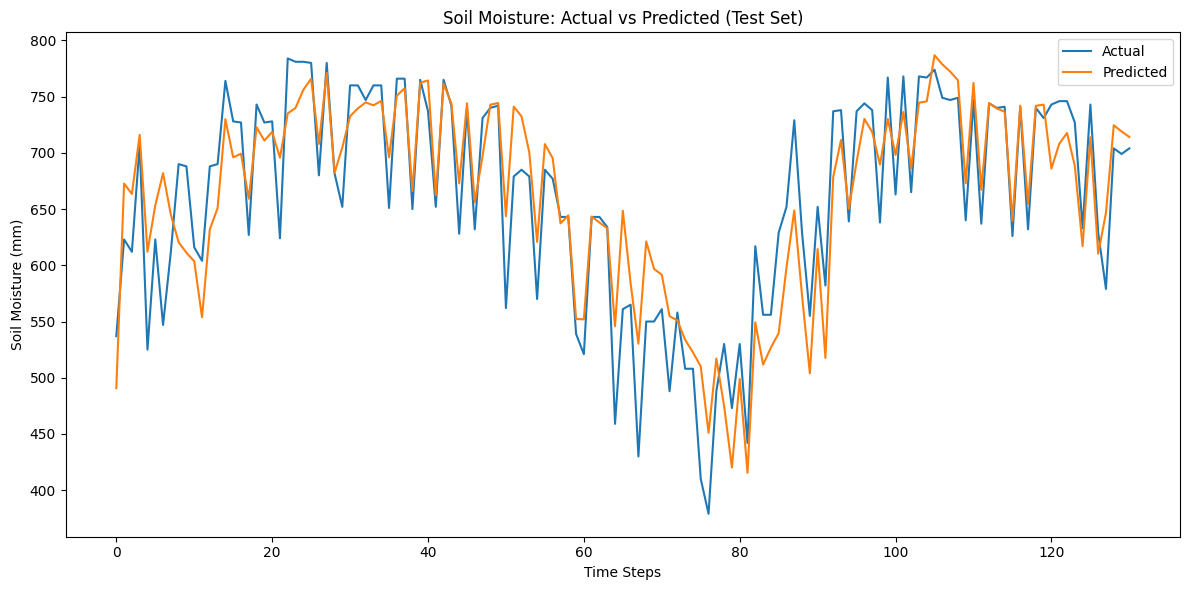

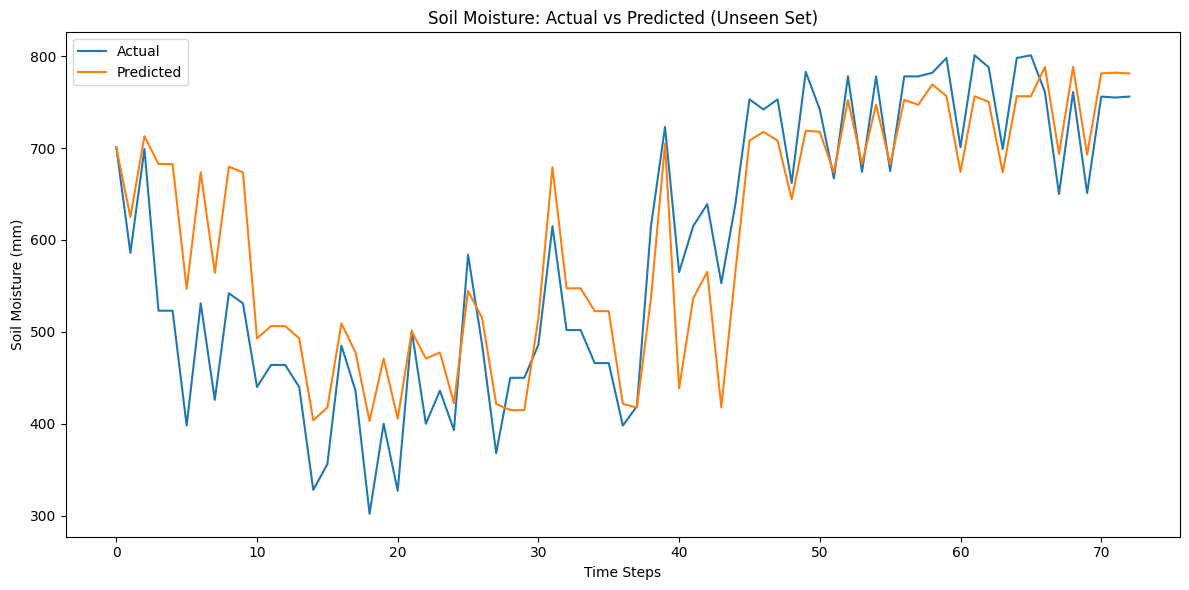

In [13]:
# Split into seen (90%) and unseen (10%) sets
seen_size = int(len(df) * 0.9)
X_seen = X[:seen_size]
y_seen = y[:seen_size]
X_unseen = X[seen_size:]
y_unseen = y[seen_size:]

# Split seen data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_seen, y_seen, test_size=0.2, random_state=42, shuffle=False
)

# Define parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,  # 10-fold cross-validation
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Initialize model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)

# Implement Rolling Forecast Origin Method
# Use the training data and incrementally add test data points
train_size = len(X_train)
test_size = len(X_test)
predictions = []
actuals = []

for i in range(test_size):
    # Train on all available training data
    X_train_rolling = X_seen[:train_size + i]
    y_train_rolling = y_seen[:train_size + i]

    # Fit the model
    best_rf.fit(X_train_rolling, y_train_rolling)

    # Predict the next point
    next_pred = best_rf.predict([X_seen.iloc[train_size + i]])
    predictions.append(next_pred[0])
    actuals.append(y_seen.iloc[train_size + i])

# Calculate metrics for the test set
rmse_test = sqrt(mean_squared_error(actuals, predictions))
mae_test = mean_absolute_error(actuals, predictions)

# Calculate AIC and BIC
n = len(actuals)
k = X.shape[1] + 1  # number of parameters (+1 for intercept)
rss = sum((np.array(actuals) - np.array(predictions))**2)
mse = rss / n
aic = n * log(mse) + 2 * k
bic = n * log(mse) + k * log(n)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE: {mae_test:.3f}")
print(f"AIC: {aic:.3f}")
print(f"BIC: {bic:.3f}")

# Predict on the unseen set
best_rf.fit(X_seen, y_seen)  # Train on all seen data
unseen_predictions = best_rf.predict(X_unseen)

# Calculate metrics for the unseen set
rmse_unseen = sqrt(mean_squared_error(y_unseen, unseen_predictions))
mae_unseen = mean_absolute_error(y_unseen, unseen_predictions)

# Calculate AIC and BIC for unseen data
n_unseen = len(y_unseen)
rss_unseen = sum((np.array(y_unseen) - np.array(unseen_predictions))**2)
mse_unseen = rss_unseen / n_unseen
aic_unseen = n_unseen * log(mse_unseen) + 2 * k
bic_unseen = n_unseen * log(mse_unseen) + k * log(n_unseen)

print(f"\nUnseen RMSE: {rmse_unseen:.3f}")
print(f"Unseen MAE: {mae_unseen:.3f}")
print(f"Unseen AIC: {aic_unseen:.3f}")
print(f"Unseen BIC: {bic_unseen:.3f}")

# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Soil Moisture: Actual vs Predicted (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Plot actual vs predicted for unseen set
plt.figure(figsize=(12, 6))
plt.plot(y_unseen.values, label='Actual')
plt.plot(unseen_predictions, label='Predicted')
plt.title('Soil Moisture: Actual vs Predicted (Unseen Set)')
plt.xlabel('Time Steps')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.tight_layout()
plt.show()

### Prediction of Soil Moisture for Future Dates


Future soil moisture predictions for each municipality (next 6 months):
Pudtol: 771.73, 728.33, 696.31, 656.21, 631.84, 589.77
Kabugao: 670.66, 654.35, 684.40, 669.00, 677.49, 675.74
Santa Marcela: 773.18, 732.73, 698.34, 661.88, 624.63, 589.70
Calanasan: 673.79, 658.22, 678.69, 672.57, 684.97, 686.56
Flora: 771.73, 728.33, 696.31, 656.21, 631.84, 589.77
Conner: 745.83, 720.37, 688.82, 648.43, 625.07, 605.77
Luna: 773.18, 732.73, 698.34, 661.88, 624.63, 589.70


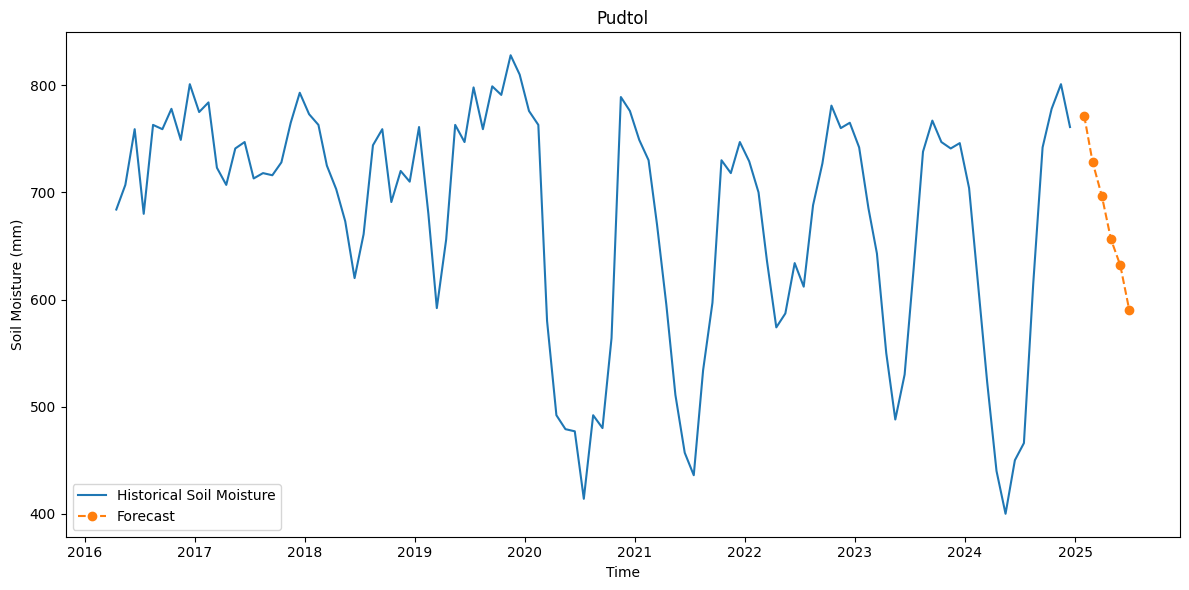

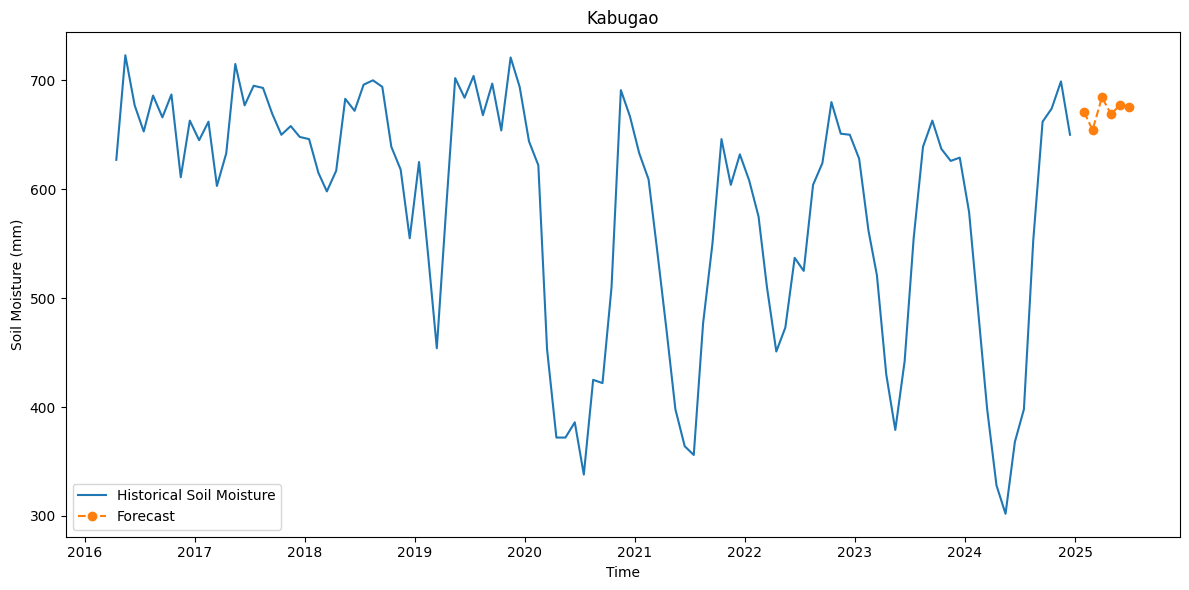

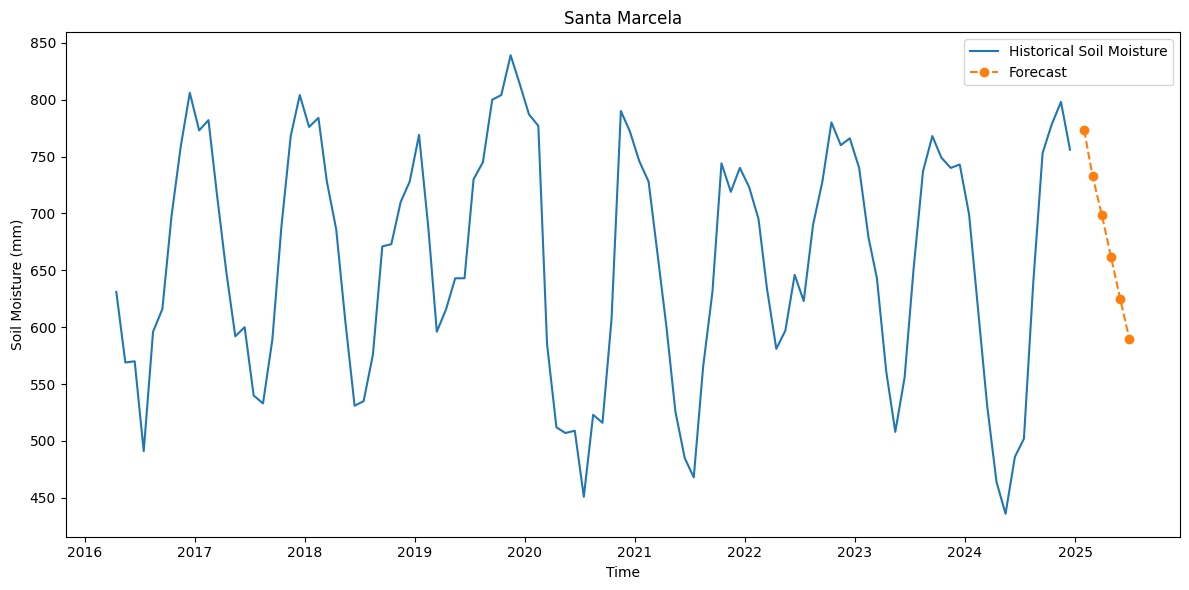

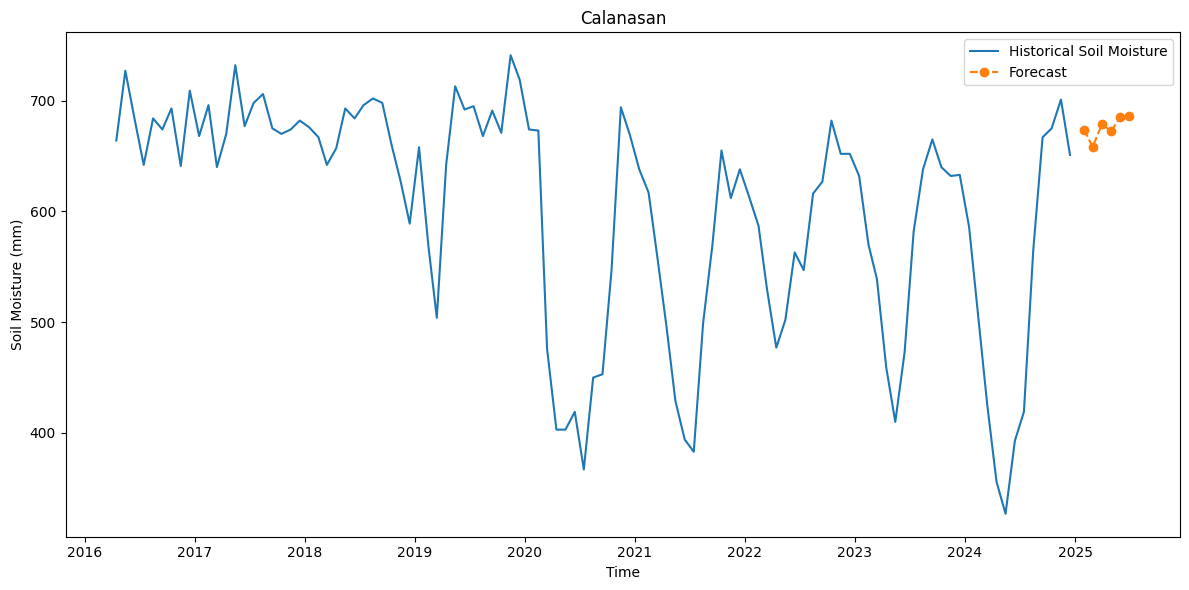

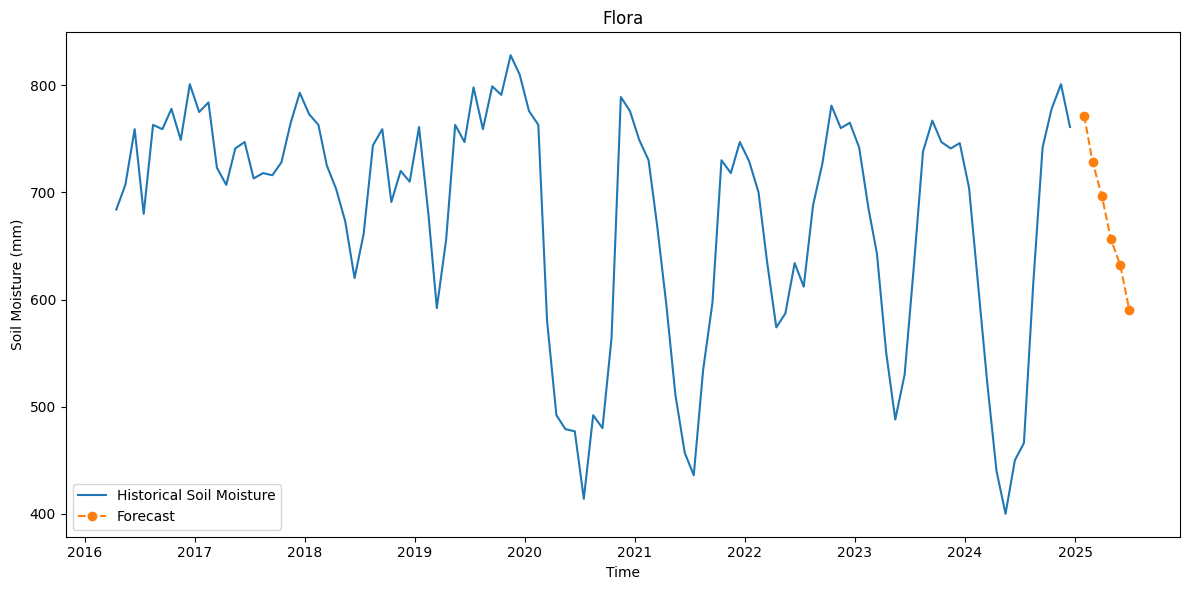

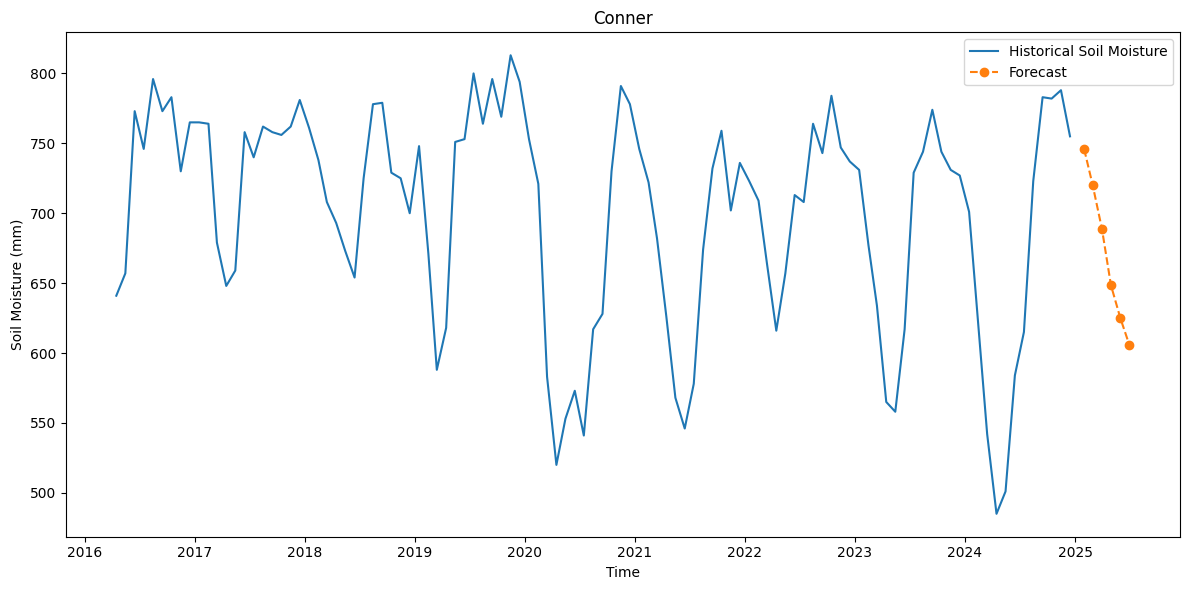

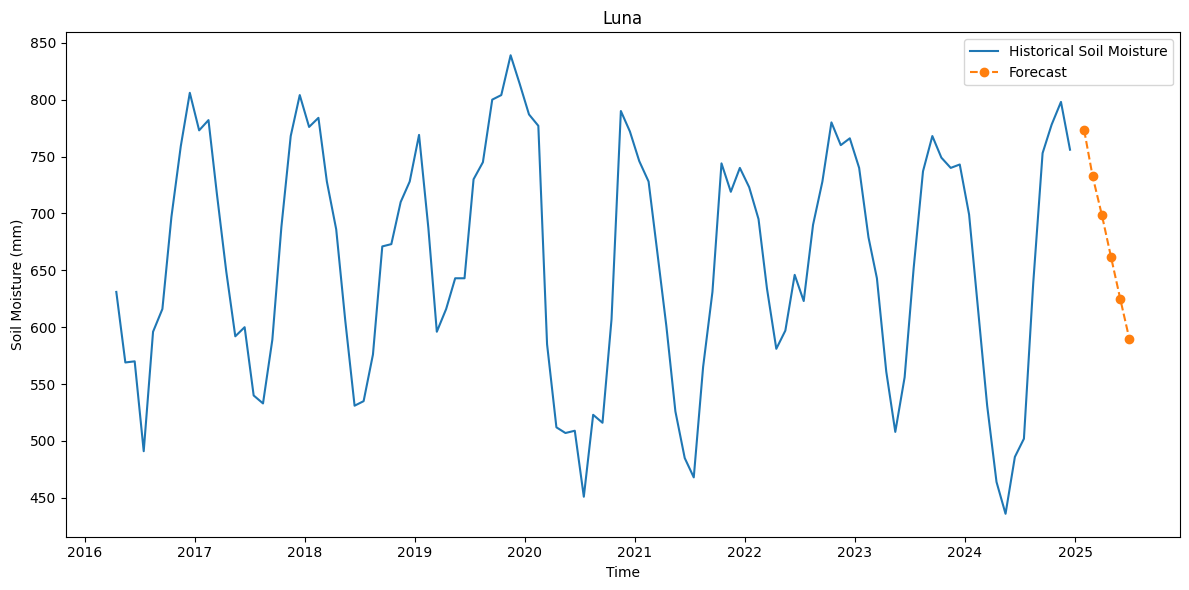

In [14]:
import numpy as np
import pandas as pd

# Set forecast horizon (number of future periods)
n_future = 6  # e.g., forecast for 6 months ahead

# Create a dictionary to hold the forecast for each municipality
municipality_forecasts = {}

for municipality in df['Municipal'].unique():
    # Select and sort data for the municipality
    muni_data = df[df['Municipal'] == municipality].sort_index()
    # Use the last three available soil moisture measurements
    recent_values = list(muni_data['Soil Moisture (mm)'].values[-3:])
    forecasts = []

    # Recursive forecasting for the horizon
    for i in range(n_future):
        # Construct the features vector as [lag1, lag2, lag3]
        features = np.array([recent_values[-1], recent_values[-2], recent_values[-3]]).reshape(1, -1)
        pred = best_rf.predict(features)[0]
        forecasts.append(pred)
        # Update recent values: drop the oldest and append the forecast
        recent_values.append(pred)
        recent_values.pop(0)

    municipality_forecasts[municipality] = forecasts

# Generate future dates based on the monthly frequency using the index
future_dates = pd.date_range(start=df.index.max(), periods=n_future + 1, freq='M')[1:]



print("\nFuture soil moisture predictions for each municipality (next 6 months):")
for muni, preds in municipality_forecasts.items():
    preds_str = ", ".join([f"{p:.2f}" for p in preds])
    print(f"{muni}: {preds_str}")

# Uncomment the following lines if you want to visualize the predictions for the overall Apayao province
# Aggregate municipality forecasts for overall prediction
# For each forecasted time step, compute the mean across municipalities
# overall_forecast = np.mean([np.array(forecasts) for forecasts in municipality_forecasts.values()], axis=0)
# print("\nPredicted overall soil moisture for Apayao for future dates:")
# for date, pred in zip(future_dates, overall_forecast):
#     print(f"{date.strftime('%Y-%m')}: {pred:.2f} mm")
#
# # Aggregate historical soil moisture by taking the mean for each timestamp
# historical_series = df.groupby(df.index)['Soil Moisture (mm)'].mean()
#
# # Create a Series for the forecast using the previously computed overall_forecast and future_dates
# forecast_series = pd.Series(overall_forecast, index=future_dates)
#
# plt.figure(figsize=(12, 6))
# plt.plot(historical_series.index, historical_series.values, label='Historical Soil Moisture')
# plt.plot(forecast_series.index, forecast_series.values, label='Forecasted Soil Moisture', marker='o', linestyle='--')
# plt.xlabel("Time")
# plt.ylabel("Soil Moisture (mm)")
# plt.title("Historical and Forecasted Soil Moisture for Apayao")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Get the list of municipalities
municipalities = df['Municipal'].unique()

for municipality in municipalities:
    plt.figure(figsize=(12, 6))

    # Extract historical data for the municipality and sort by the datetime index
    muni_data = df[df['Municipal'] == municipality].sort_index()
    historical = muni_data['Soil Moisture (mm)']

    # Retrieve municipality forecast and create a forecast series with the future dates
    forecasts = municipality_forecasts[municipality]
    forecast_series = pd.Series(forecasts, index=future_dates)

    # Plot historical and forecast data
    plt.plot(historical.index, historical, label='Historical Soil Moisture')
    plt.plot(forecast_series.index, forecast_series, label='Forecast', marker='o', linestyle='--')
    plt.title(municipality)
    plt.xlabel("Time")
    plt.ylabel("Soil Moisture (mm)")
    plt.legend()
    plt.tight_layout()
    plt.show()